In [17]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [18]:
df = pd.read_csv("../dataset.csv")
df.shape

(2930, 82)

In [19]:
df['TotalBath'] = df['Full Bath'] + 0.5 * df['Half Bath'] + .5 *  df['Bsmt Full Bath'] + .25* df['Bsmt Half Bath']
df['Total Indoor SF'] = df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area'] 

corrmatrix = df[['TotalBath', 'SalePrice']].corr()
print(corrmatrix)
corrmatrix = df[['Total Indoor SF', 'SalePrice']].corr()
print(corrmatrix)

df[['TotalBath', 'Total Indoor SF']].head()

           TotalBath  SalePrice
TotalBath    1.00000    0.65004
SalePrice    0.65004    1.00000
                 Total Indoor SF  SalePrice
Total Indoor SF         1.000000   0.821317
SalePrice               0.821317   1.000000


,TotalBath,Total Indoor SF
0,1.5,3264.0
1,1.0,2508.0
2,1.5,2970.0
3,3.0,4742.0
4,2.5,3039.0


In [162]:

# Print out all columns with less than len(df) non-null values
null_counts = df.isnull().sum() 

non_null_counts = len(df) - null_counts
cols_with_missing = non_null_counts[non_null_counts < len(df)]

# for col, count in cols_with_missing.items():
 #   print(f"{col:20} {count}, {df[col].dtype}")

 # Only numeric columns
skew_values = df.skew(numeric_only=True)

# Sort by absolute skewness (most skewed first)
print(skew_values.sort_values(key=abs, ascending=False))

Misc Val           21.999788
Pool Area          16.939142
Lot Area           12.820898
Low Qual Fin SF    12.118162
3Ssn Porch         11.403795
Kitchen AbvGr       4.313825
BsmtFin SF 2        4.139978
Enclosed Porch      4.014446
Screen Porch        3.957467
Bsmt Half Bath      3.940795
Mas Vnr Area        2.606985
Open Porch SF       2.535386
Wood Deck SF        1.842678
SalePrice           1.743500
Lot Frontage        1.499067
1st Flr SF          1.469429
BsmtFin SF 1        1.416182
MS SubClass         1.357579
Gr Liv Area         1.274110
Total Bsmt SF       1.156204
Bsmt Unf SF         0.923053
2nd Flr SF          0.866457
TotRms AbvGrd       0.753543
Fireplaces          0.739215
Half Bath           0.697713
Bsmt Full Bath      0.616639
Year Built         -0.604462
Overall Cond        0.574429
Year Remod/Add     -0.451863
Garage Yr Blt      -0.384672
Bedroom AbvGr       0.305694
Garage Area         0.241994
Garage Cars        -0.219836
Mo Sold             0.192596
Overall Qual  

In [20]:
# Make a copy of df so we can compute the median value of the missing numbers necessary to stratify based on Total Indoor SF
df_temp = df.copy()
temp_train_set, temp_test_set = train_test_split(df, test_size=0.2, random_state=42)

# 2. Compute median from training set
median_total_indoor_of_training_set = temp_train_set['Total Indoor SF'].median()

# 3. Fill missing values in both sets using training median
temp_train_set['Total Indoor SF'] = temp_train_set['Total Indoor SF'].fillna(median_total_indoor_of_training_set)
temp_test_set['Total Indoor SF'] = temp_test_set['Total Indoor SF'].fillna(median_total_indoor_of_training_set)

df_with_filled_values = pd.concat([temp_train_set, temp_test_set], ignore_index=True)

df_with_filled_values['Total Indoor SF'] = pd.qcut(df_with_filled_values['Total Indoor SF'], 
                                    q=5,
                                    labels = [0, 1, 2, 3, 4],
                                    duplicates='drop')


strat_train_set, strat_test_set = train_test_split(df_with_filled_values, test_size=0.2, stratify=df_with_filled_values['Total Indoor SF'], random_state=42)

print("ratios in housing set")
print(df_with_filled_values['Total Indoor SF'].value_counts() / len(df_with_filled_values))

print("ratios in stratified set")
print(strat_test_set['Total Indoor SF'].value_counts() / len(strat_test_set))


print("")
pd.set_option('display.width', None) 
print(strat_train_set.columns)


ratios in housing set
Total Indoor SF
0    0.200683
2    0.200000
3    0.200000
4    0.200000
1    0.199317
Name: count, dtype: float64
ratios in stratified set
Total Indoor SF
0    0.201365
1    0.199659
2    0.199659
3    0.199659
4    0.199659
Name: count, dtype: float64

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd

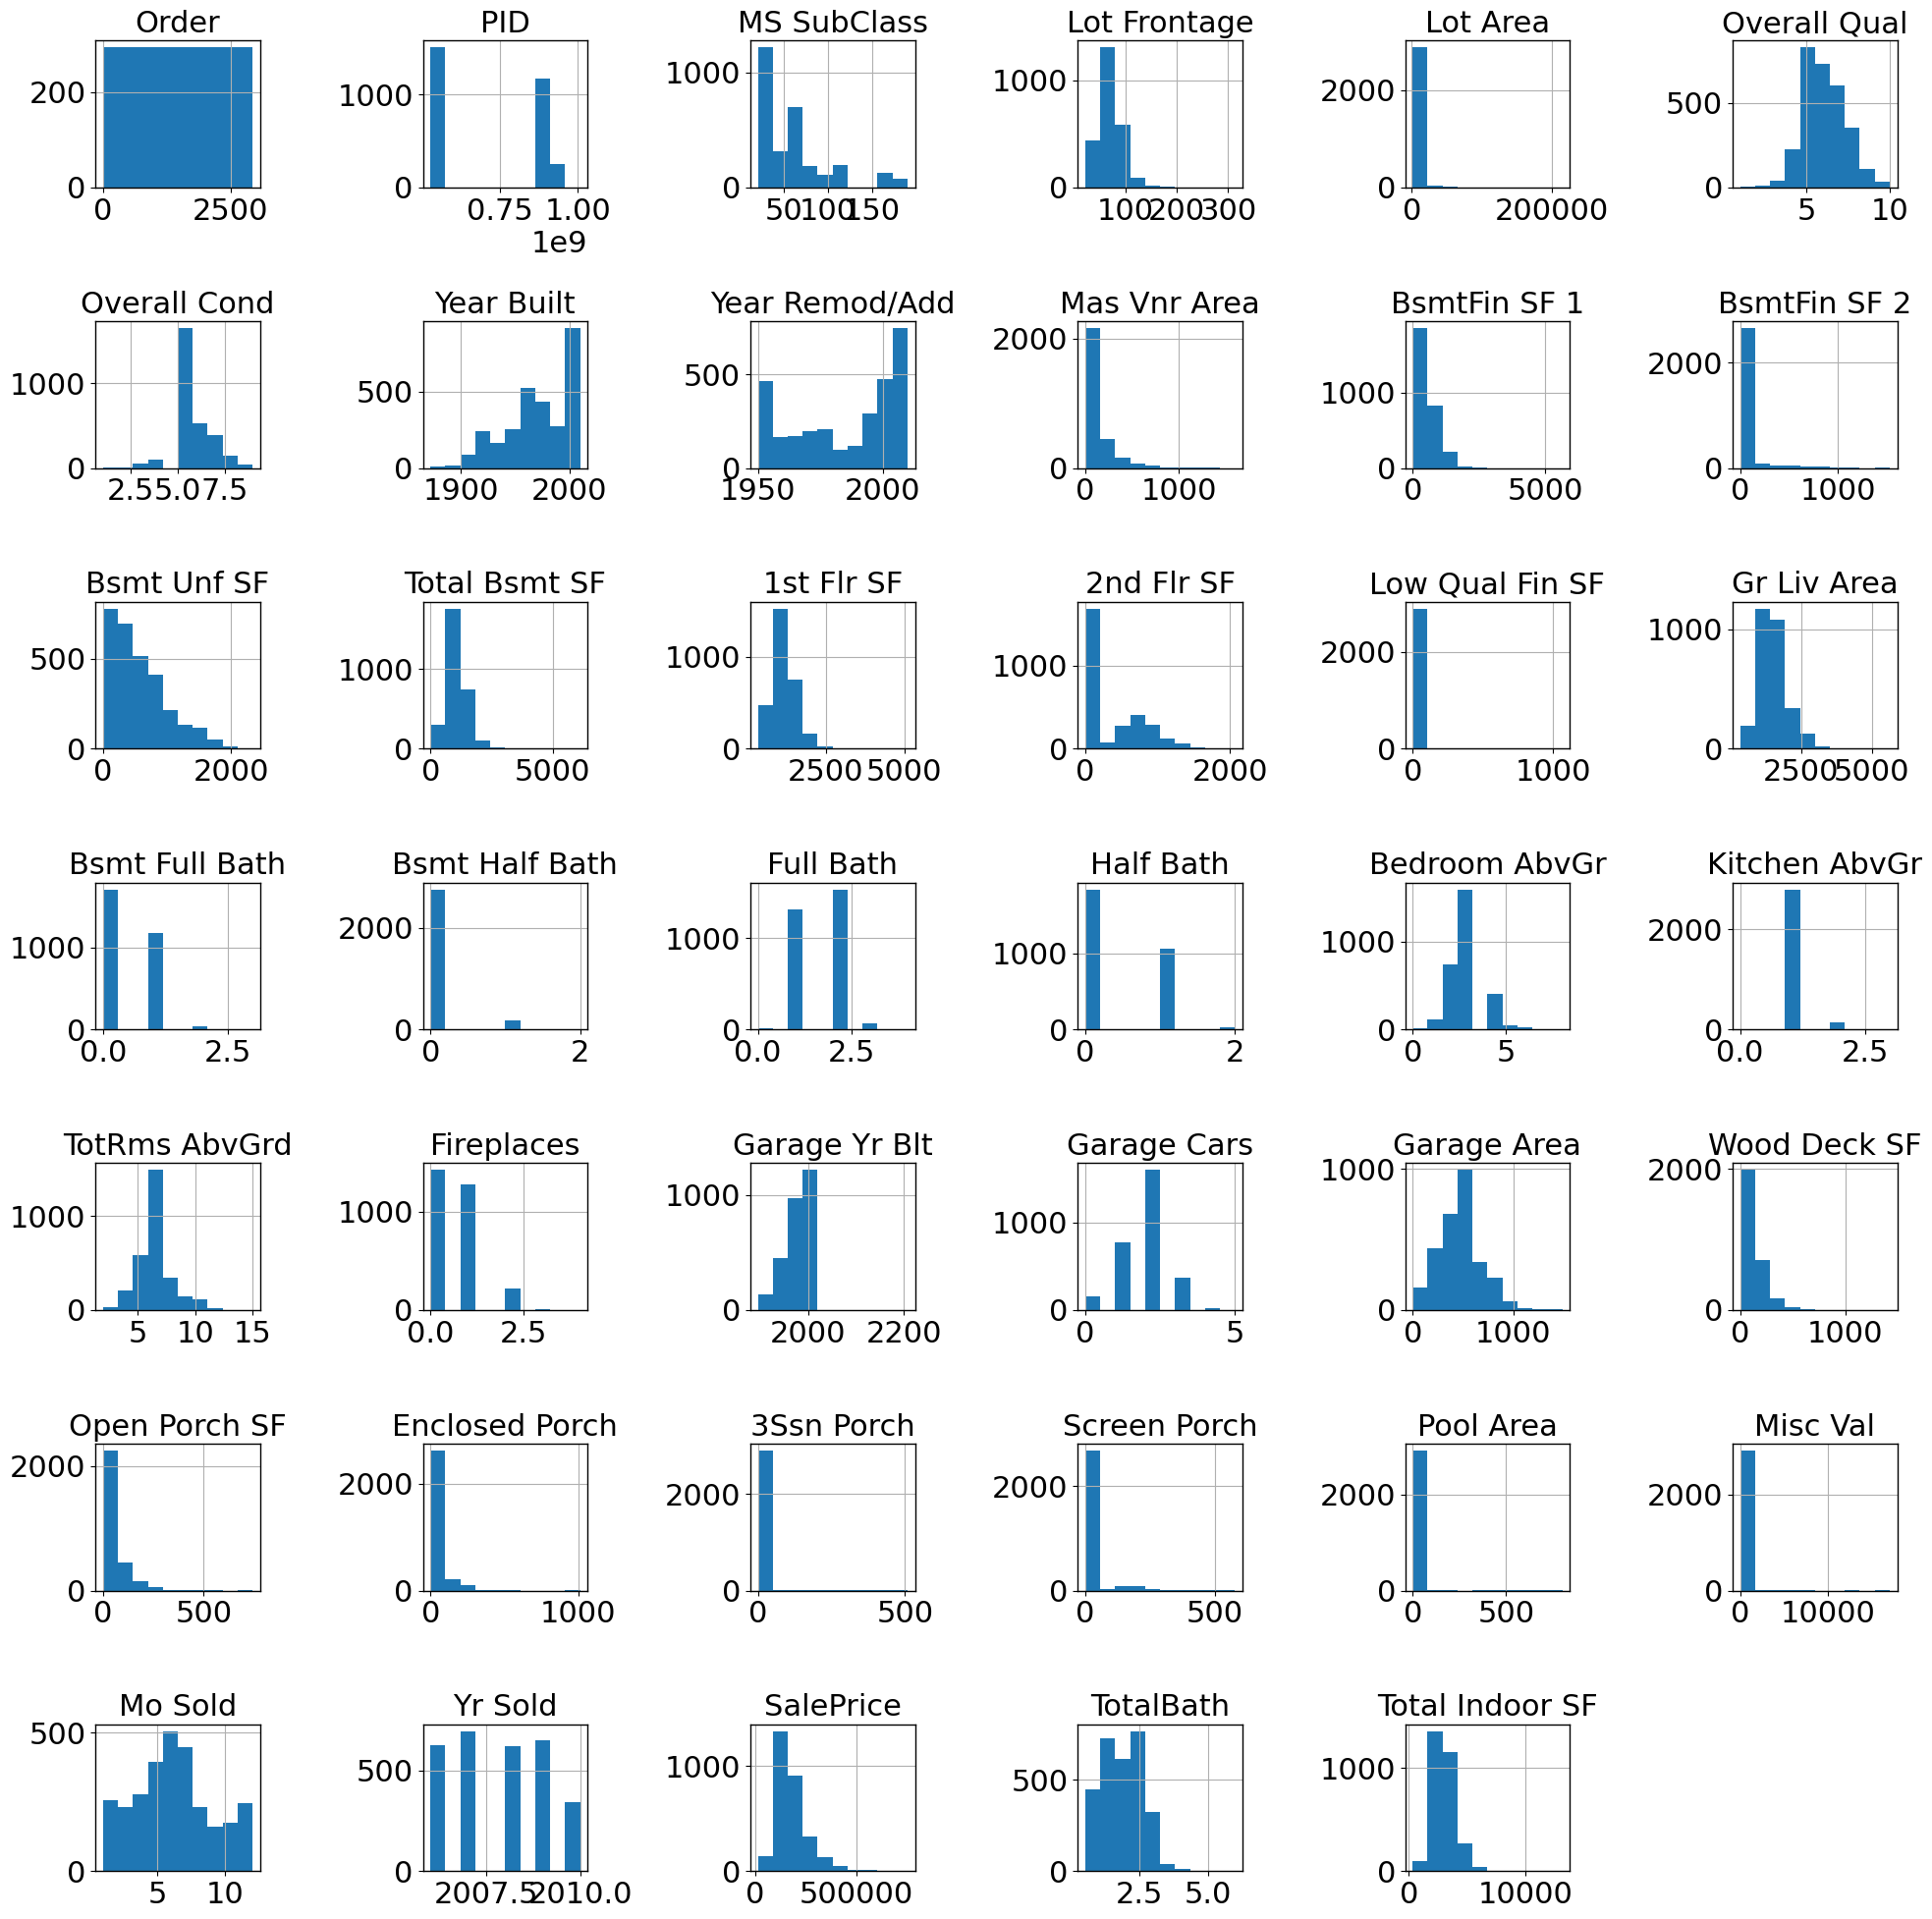

In [ ]:

df_predictors = strat_train_set.drop('SalePrice', axis=1)
df_labels = strat_train_set['SalePrice'].copy()



df.select_dtypes(include=[np.number]).hist(figsize=(20, 20))

log_attributes = (
    "MS SubClass",
    "Lot Frontage",
    "Mas Vnr Area",
    "BsmtFin SF 1",
    "Bsmt Unf SF",
    "Total Bsmt SF",
    "1st Flr SF",
    "2nd Flr SF",
    "Gr Liv Area",
    "Wood Deck SF",
    "Open Porch SF",
    "Enclosed Porch",
    "3Ssn Porch",
    "Screen Porch",
    "Pool Area",
    "Misc Val",
)

df_predictors_numerical = df_predictors.select_dtypes(include=[np.number]).drop(columns=list(log_attributes), axis=1)
df_predictors_categorical = df_predictors.select_dtypes(include=[object])


cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder(handle_unknown='ignore')
)

log_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                 FunctionTransformer(np.log1p),
                                 StandardScaler())

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

preprocessing = ColumnTransformer([
    ('num', num_pipeline, df_predictors_numerical.columns),
    ('cat', cat_pipeline, df_predictors_categorical.columns),
    ('log_num', log_num_pipeline, log_attributes)
])

In [31]:

print(df_predictors.shape)
print(df_labels.shape)

print("")
pd.set_option('display.width', None) 
print(df_predictors.columns)

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(df_predictors, df_labels)

df_predictions = lin_reg.predict(df_predictors)
print(df_predictions[5:10].round(2))
print(df_labels.iloc[5:10].values)

lin_rmse = root_mean_squared_error(df_labels, df_predictions)
print(lin_rmse)

mae = mean_absolute_error(df_labels, df_predictions)
print(mae)


(2344, 83)
(2344,)

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Ga

[294270.2  129925.01 121312.94  90244.35  56813.89]
[250000 137000 128500  93000  12789]
27015.41618523342
16211.930295405271


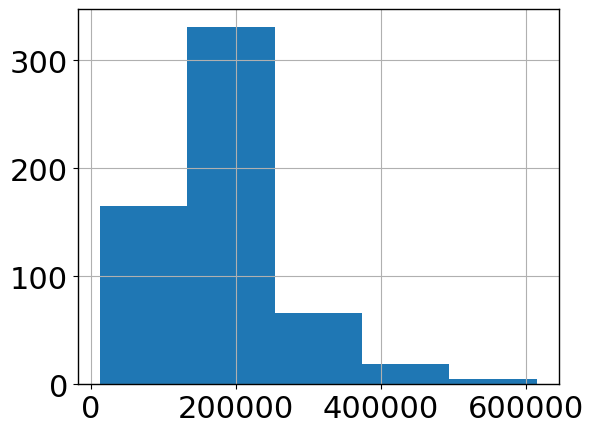

In [32]:
df_predictors = strat_test_set.drop('SalePrice', axis=1)
df_labels = strat_test_set['SalePrice'].copy()
df_labels.hist(bins=5)
df_predictions = lin_reg.predict(df_predictors)

print(df_predictions[5:10].round(2))
print(df_labels.iloc[5:10].values)

lin_rmse = root_mean_squared_error(df_labels, df_predictions)
print(lin_rmse)

mae = mean_absolute_error(df_labels, df_predictions)
print(mae)




In [152]:

corr = df_numerical.corr()

# fig, ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, ax=ax)

print(corr["SalePrice"].sort_values(key=abs, ascending=False))

SalePrice          1.000000
Total Indoor SF    0.821317
Overall Qual       0.799262
Gr Liv Area        0.706780
TotalBath          0.650040
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID               -0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Screen Porch       0.112151
Overall Cond      -0.101697
MS SubClass       -0.085092
Pool Area          0.068403
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Mo Sold            0

In [153]:
# Drop columns 
df.drop(columns=[
    "PID", 
    "Pool QC", 
    "Alley", 
    "Misc Feature", 
    "Yr Sold", 
    "Mo Sold", 
    "Misc Val", 
    'Half Bath', 
    'Full Bath'
    ], inplace=True)

In [154]:
print(df_numerical_clean.skew().sort_values(ascending=False))

NameError: name 'df_numerical_clean' is not defined

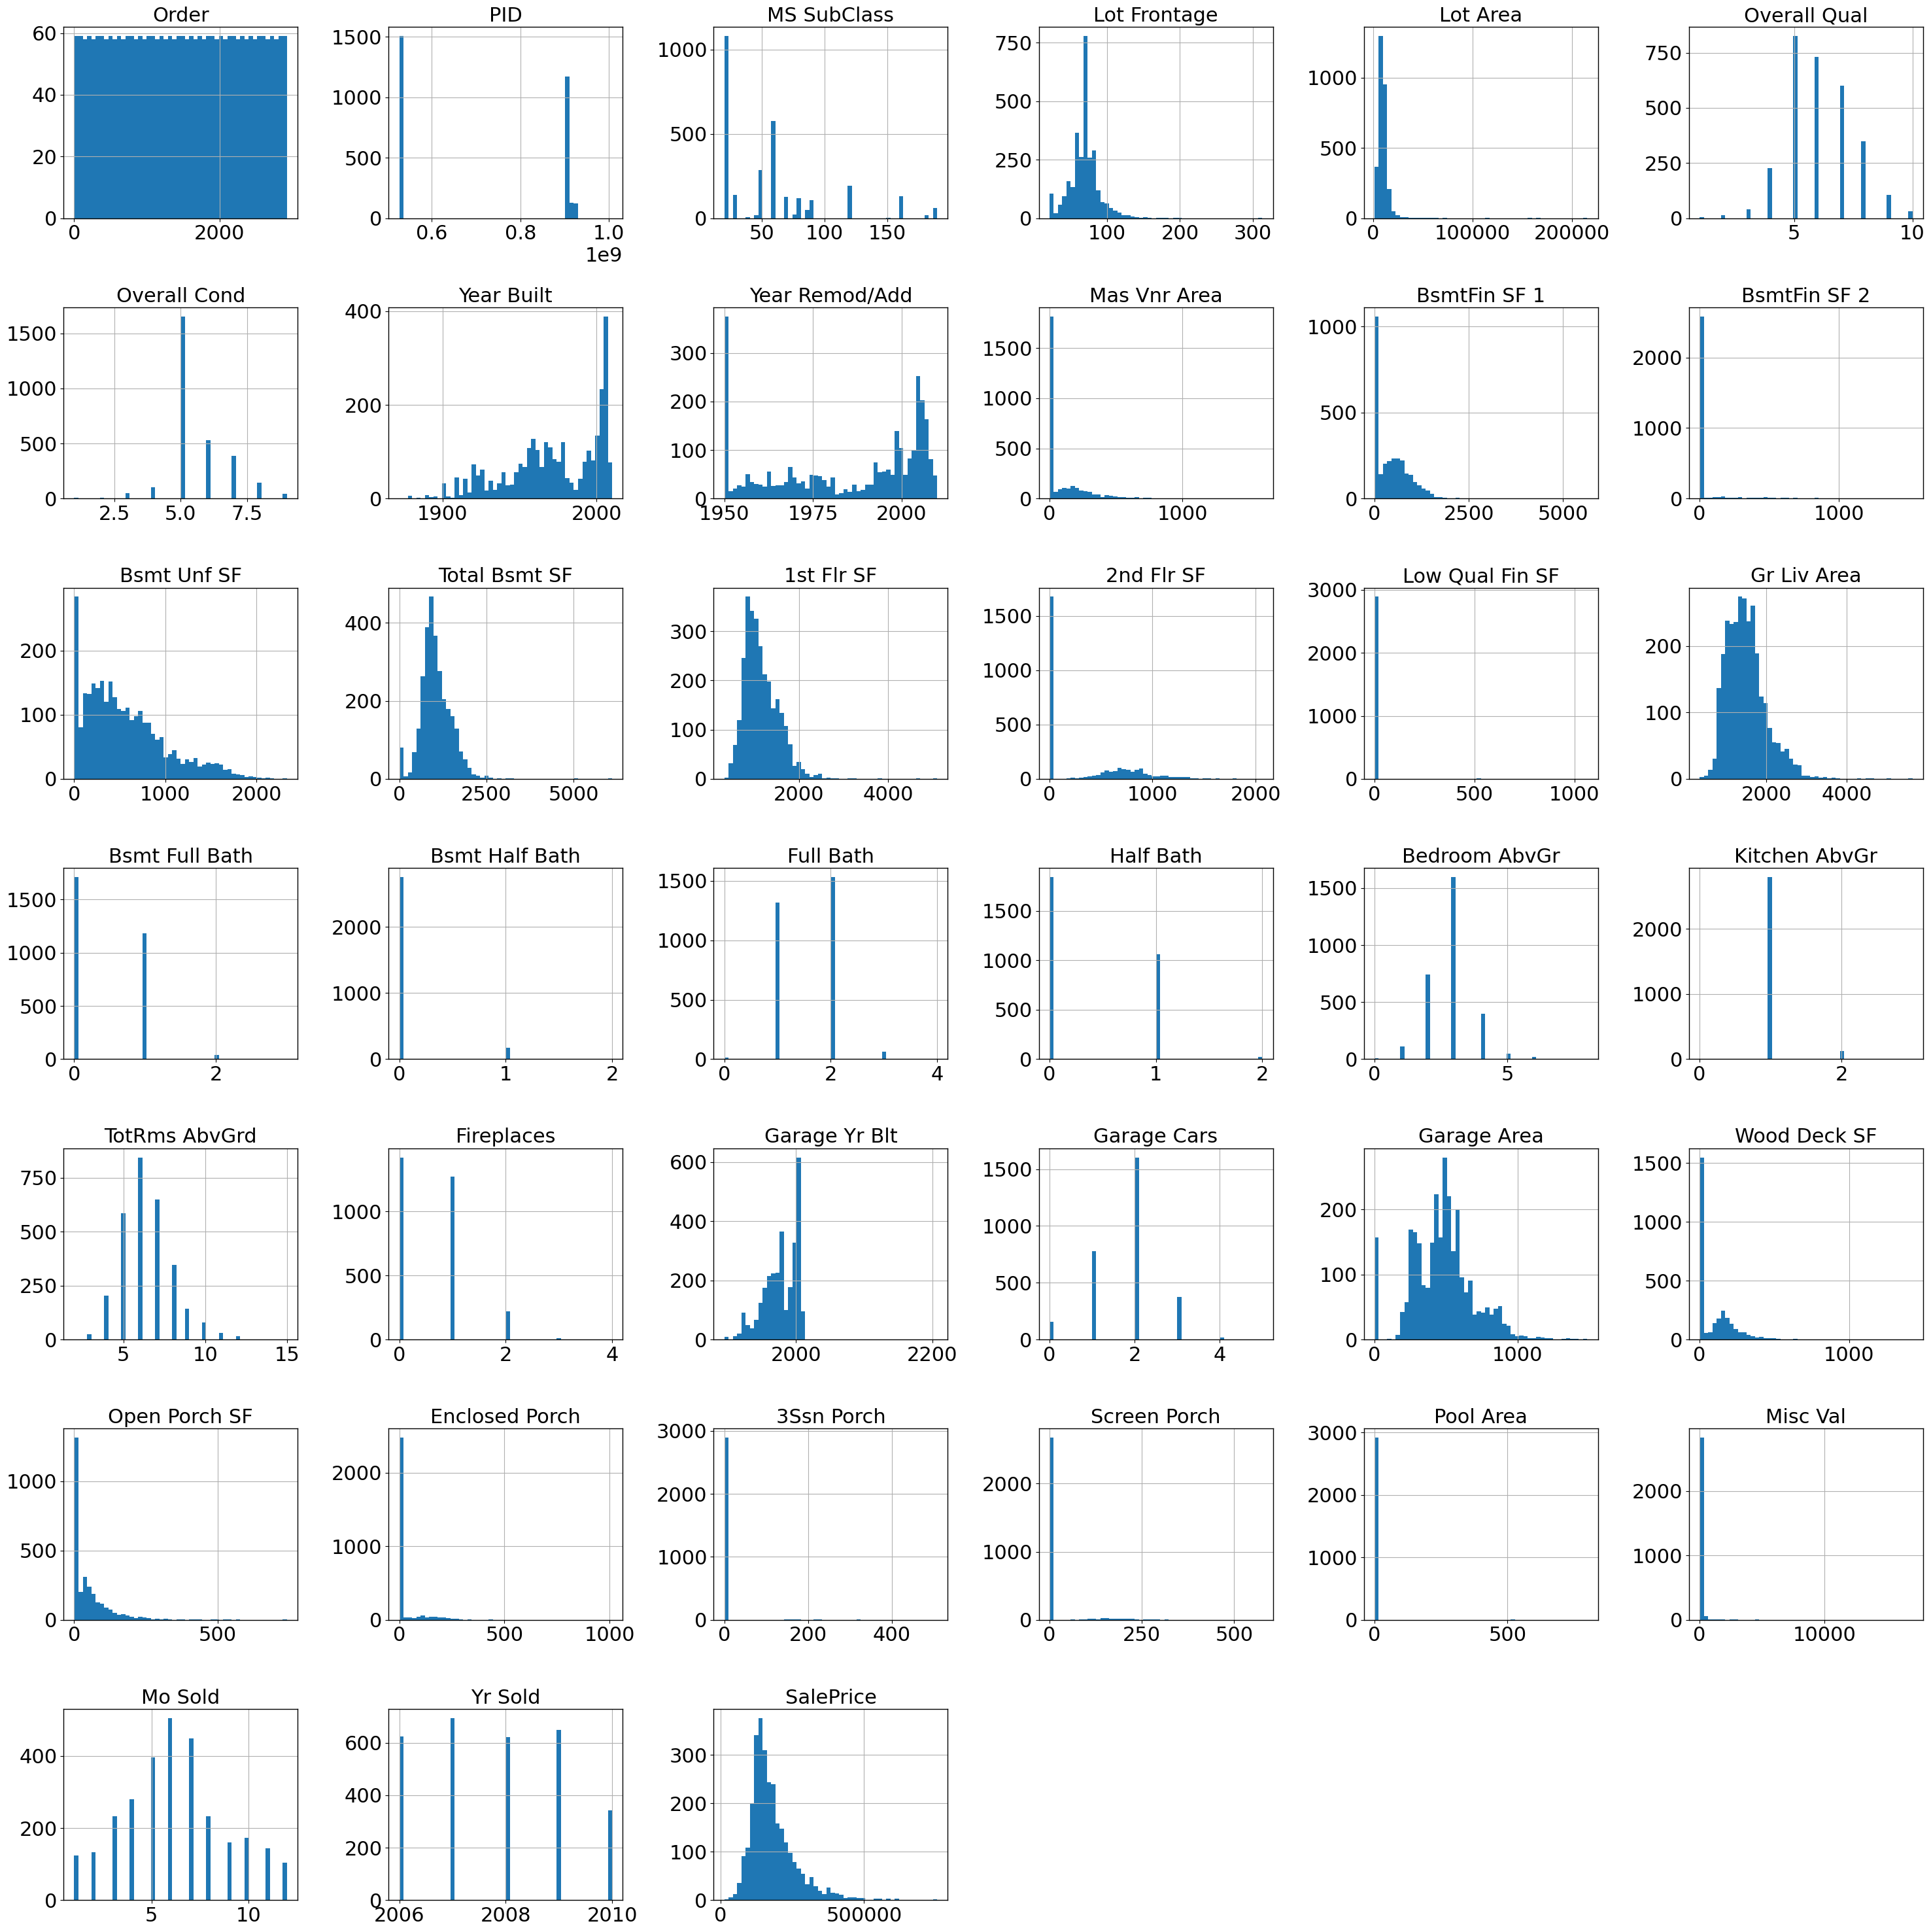

In [ ]:
df_numerical_clean.hist(bins=50, figsize=(30, 30));

In [155]:
# Scatter plots to figure out what data needs to be cleaned

corr = df.select_dtypes(include=[np.number]).corr()

att = ["Overall Qual",
       "Gr Liv Area",
       "Garage Cars",
       "Garage Area",
       "Total Bsmt SF",
       "1st Flr SF",
       "Year Built",
       "TotalBath",
       "Year Remod/Add",
       "Garage Yr Blt"]

df_melt = df.melt(id_vars='SalePrice', value_vars=att,
                  var_name='Feature', value_name='Value')

# Horizontal layout with 3 plots per row
g = sns.FacetGrid(df_melt, col='Feature', col_wrap=3, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.scatterplot, x='Value', y='SalePrice', s=20)
g.set_axis_labels("", "SalePrice")
plt.tight_layout()
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['TotalBath']"